# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
region_0 = pd.read_csv('/datasets/geo_data_0.csv')
region_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [3]:
region_1 = pd.read_csv('/datasets/geo_data_1.csv')
region_1

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


In [4]:
region_2 = pd.read_csv('/datasets/geo_data_2.csv')


Проверка на пропущенный значения

In [5]:
region_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [6]:
region_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [7]:
region_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Проверка на дубликаты

In [8]:
li = [region_0, region_1, region_2]
def check_duplicates(sheet):
    result = []
    for i in sheet:
        if i.duplicated().sum() == 0:
            result.append(0) #Если в итоговом списке 0, значит дубликаты отсутствуют
        else:
            result.append(1)
    return result
check_duplicates(li)

[0, 0, 0]

In [9]:
for i in range(len(li)):
    print('Inforamtion about region_data type', i)
    print(li[i].info())

Inforamtion about region_data type 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Inforamtion about region_data type 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Inforamtion about region_data type 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null floa

Из данных нужно исключить признак, который не влияет на целевой, поэтому удалим из всех таблиц столбец id

In [10]:
region_0 = region_0.drop('id', axis=1)
region_1 = region_1.drop('id', axis=1)
region_2 = region_2.drop('id', axis=1)

Подгдотовка признаков для каждого из регионов

In [11]:
features_0 = region_0.drop('product', axis=1)
target_0 = region_0['product']
features_1 = region_1.drop('product', axis=1)
target_1 = region_1['product']
features_2 = region_2.drop('product', axis=1)
target_2 = region_2['product']

Разбиение на валидационную и обучающую выборки

In [12]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, random_state=12345, test_size=0.25)

In [13]:
features_train_0 = features_train_0.reset_index(drop=True)
features_valid_0 = features_valid_0.reset_index(drop=True)
target_train_0 = target_train_0.reset_index(drop=True)
target_valid_0 = target_valid_0.reset_index(drop=True)

In [14]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, random_state=12345, test_size=0.25)

In [15]:
features_train_1 = features_train_1.reset_index(drop=True)
features_valid_1 = features_valid_1.reset_index(drop=True)
target_train_1 = target_train_1.reset_index(drop=True)
target_valid_1 = target_valid_1.reset_index(drop=True)

In [16]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, random_state=12345, test_size=0.25)

In [17]:
features_train_2 = features_train_2.reset_index(drop=True)
features_valid_2 = features_valid_2.reset_index(drop=True)
target_train_2 = target_train_2.reset_index(drop=True)
target_valid_2 = target_valid_2.reset_index(drop=True)

## Обучение и проверка модели

In [18]:
def region_information(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    mse = mean_squared_error(predictions, target_valid)
    rmse = np.sqrt(mse)
    average_reserve = predictions.mean()
    return predictions, rmse, average_reserve

In [19]:
predictions_0, rmse_0, average_reserve_0 = region_information(
    features_train_0, target_train_0, features_valid_0, target_valid_0)

In [20]:
predictions_1, rmse_1, average_reserve_1 = region_information(
    features_train_1, target_train_1, features_valid_1, target_valid_1)

In [21]:
predictions_2, rmse_2, average_reserve_2 = region_information(
    features_train_2, target_train_2, features_valid_2, target_valid_2)

Информация о регионе 0

In [22]:
print('Information about region_0:')
print('Average reserve in region_0: {}'.format(average_reserve_0))
print('Rmse in region_0: {}'.format(rmse_0))

Information about region_0:
Average reserve in region_0: 92.59256778438038
Rmse in region_0: 37.5794217150813


Информация о регионе 1

In [23]:
print('Information about region_1:')
print('Average reserve in region_1: {}'.format(average_reserve_1))
print('Rmse in region_1: {}'.format(rmse_1))

Information about region_1:
Average reserve in region_1: 68.728546895446
Rmse in region_1: 0.893099286775616


Информация о регионе 2

In [24]:
print('Information about region_2:')
print('Average reserve in region_2: {}'.format(average_reserve_2))
print('Rmse in region_2: {}'.format(rmse_2))

Information about region_2:
Average reserve in region_2: 94.96504596800489
Rmse in region_2: 40.02970873393434


Вывод: Самые большие средние запасы предсказанного сырья находятся в регионе 2, чуть меньше запасов в регионе 0, однако в каждом из этих регионов показатель rmse очень велик, в то время как в регионе 1 средний объем предсказанных запасов меньше, но они гораздо точнее, более того, считая показатель rmse погрешностью, можно сказать, что минимальные предсказанные запасы в регионе 1 больше, чем минимальные предсказанные запасы в регионе 0 и в регионе2

## Подготовка к расчёту прибыли

Расчет достаточного объема сырья для безубыточной разработки новой скважины

In [25]:
all_holes_budget = 10**10 #бюджет на разработку всех скважин в регионе
barrel_price = 450
holes_amount = 200 #количество скважин в регионе

In [26]:
oil_volume_in_one_hole = all_holes_budget / (barrel_price*(10**3) * holes_amount)
print('Объем в скважине, необходимый для безубыточной разработки:', round(oil_volume_in_one_hole,2), "тыс. баррелей")

Объем в скважине, необходимый для безубыточной разработки: 111.11 тыс. баррелей


Объем в одной скважине, необходимый для безубыточной разработки, больше, чем средний предсказанный объем в любом из регионов

Функция для расчета прибыли

In [27]:
def revenue(target, predictions, count):
    sort_predictions = pd.Series(predictions).sort_values(ascending=False)
    selected = target[sort_predictions.index][:count]
    return barrel_price * selected.sum()*10**3 - all_holes_budget

## Расчёт прибыли и рисков 

Исследование техникой bootstrap для региона 0

In [28]:
def bootstrap_for_models(target, predictions):
    predictions = pd.Series(predictions)
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(frac=500/len(target), replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        values.append(revenue(target_subsample, predictions_subsample, 200))
    return pd.Series(values)

In [29]:
def quant(bootstrap_result):
    res = []
    res.append(bootstrap_result.quantile(q=0.025))
    res.append(bootstrap_result.quantile(q = 0.975))
    return tuple(res)

In [30]:
bootstr_0 = bootstrap_for_models(target_valid_0, predictions_0)
bootstr_0.mean()

425938526.91059226

In [31]:
quant(bootstr_0)

(-102090094.83793654, 947976353.358369)

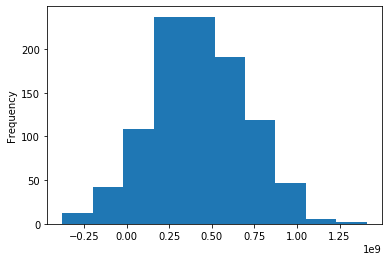

In [32]:
bootstr_0.plot(kind='hist')

In [33]:
def money_lost_probability(bootstrap_result):
    return bootstrap_result[bootstrap_result < 0].count() / 1000

In [34]:
money_lost_probability(bootstr_0)

0.06

In [35]:
bootstr_1 = bootstrap_for_models(target_valid_1, predictions_1)
bootstr_1.mean()

515222773.44328994

In [36]:
quant(bootstr_1)

(68873225.37050177, 931547591.2570496)

In [37]:
money_lost_probability(bootstr_1)

0.01

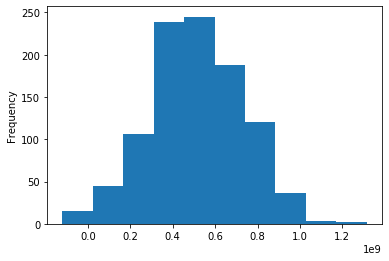

In [38]:
bootstr_1.plot(kind='hist')

In [39]:
bootstr_2 = bootstrap_for_models(target_valid_2, predictions_2)
bootstr_2.mean()

435008362.78275555

In [40]:
quant(bootstr_2)

(-128880547.32978901, 969706954.1802679)

In [41]:
money_lost_probability(bootstr_2)

0.064

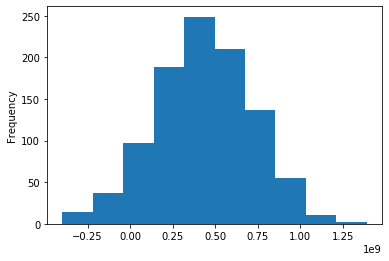

In [42]:
bootstr_2.plot(kind='hist')

На основе результатов, полученных бутстрепом можно предложить для разработки регион 1, так как там наименьшая и вероятность убытка - 1%, он один удовлетворяет условию о том, что вероятность убытка должна быть меньше 2.5%. Более того, у региона 1 для 95% доверительного интервала оба конца являются положительными, это говорит о том, что средняя прибыль с вероятностью 95% лежать в интервале (68873225.37, 931547591.26).